In [1]:
import pandas as pd
from datetime import datetime

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

In [3]:
print(tf.__version__)

2.10.1


In [4]:
df = pd.read_csv('../data/current.csv')
# df = pd.read_csv('../../training_data.csv')
df.head()
df.shape


(6490, 42)

### Cleaning

In [5]:
df.drop(df['skaterFullName'].loc[df['skaterFullName'] == 'Taylor Hall'].index, inplace=True)
df = df.drop(columns=['skaterFullName', 'teamAbbrevs', 'vs', 'shoots', 'row', 'date']) 
df = df.dropna()
df.head()

,ppPoints,gamesPlayed,position,ppUnit,avgPowerplayToi,team_PEN/GP,team_PP%,team_PK%,team_G,team_GA,...,PPGF_enemy,PPG/PG_enemy,PPO/PG_enemy,PPTOI/PG_enemy,PEN_enemy,PENMin_enemy,PENSeconds/PG_enemy,PENDrawn/GP_enemy,PPGA_enemy,PKTIO/PG_enemy
2133,0,16,L,2.0,01:46,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2134,4,24,C,1.0,02:10,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2135,3,26,C,1.0,03:14,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2137,3,26,R,2.0,01:51,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2138,2,26,D,1.0,01:43,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666


In [6]:
df['avgPowerplayToi'] = df['avgPowerplayToi'].apply(lambda x: datetime.strptime(str(x), "%M:%S").second + datetime.strptime(str(x), "%M:%S").minute * 60)


df['position'].replace(['C', 'R', 'L', 'D'], [2, 2, 2, 1], inplace=True)
df.head()

,ppPoints,gamesPlayed,position,ppUnit,avgPowerplayToi,team_PEN/GP,team_PP%,team_PK%,team_G,team_GA,...,PPGF_enemy,PPG/PG_enemy,PPO/PG_enemy,PPTOI/PG_enemy,PEN_enemy,PENMin_enemy,PENSeconds/PG_enemy,PENDrawn/GP_enemy,PPGA_enemy,PKTIO/PG_enemy
2133,0,16,2,2.0,106,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2134,4,24,2,1.0,130,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2135,3,26,2,1.0,194,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2137,3,26,2,2.0,111,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2138,2,26,1,1.0,103,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666


### Visualization

Players who scored:  786
Players who did not score:  3456


C:\Users\Logan\AppData\Local\Temp\ipykernel_13388\326808471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=concat, data=df, palette='hls')


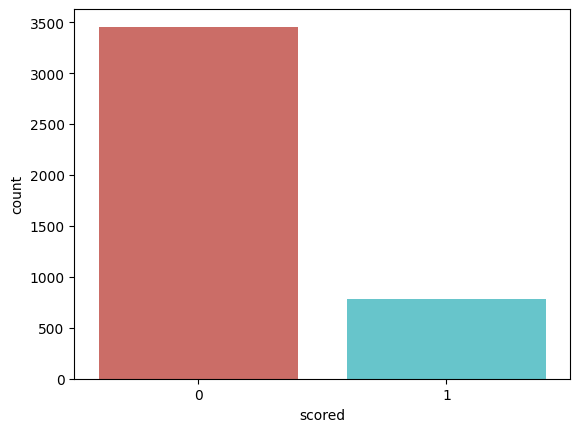

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

labels=['scored', 'no-score']

scored = df[df['scored'] == 1]['scored']
no_score = df[df['scored'] == 0]['scored']

concat = pd.concat([scored, no_score])

sns.countplot(x=concat, data=df, palette='hls')
print('Players who scored: ', len(scored))
print('Players who did not score: ', len(no_score))

In [8]:
perc = (scored.shape[0] / df['scored'].shape[0]) * 100
print(f'Percentage of players with a scored point ({scored.shape[0]}/{df["scored"].shape[0]}): {round(perc, 2)}%')

Percentage of players with a scored point (786/4242): 18.53%


### Clustering

In [9]:
# import pandas as pd
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import StandardScaler

# # Assuming df is your DataFrame containing the sample data
# # df = ...

# # Select the features for clustering
# features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_G', 'team_GA', 'team_PP%', 'PPGF', 'PPG/PG', 'PPO/PG',
#             'PPTOI/PG', 'PEN', 'PENMin', 'team_PEN/GP', 'PENSeconds/PG', 'PENDrawn/GP', 'PPGA', 'team_PK%', 'PKTIO/PG', 'enemy_G', 'enemy_GA', 'enemy_PP%',
#             'PPGF_enemy', 'PPG/PG_enemy', 'PPO/PG_enemy', 'PPTOI/PG_enemy', 'PEN_enemy', 'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENDrawn/GP_enemy',
#             'PPGA_enemy', 'enemy_PK%', 'PKTIO/PG_enemy']

# # Use StandardScaler to normalize the features
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

# # Choose the number of clusters (you may adjust this based on your data)
# silhouette_scores = []
# for n_clusters in range(2, 12):
#     # Apply K-Means clustering
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     cluster_labels = kmeans.fit_predict(df_scaled)
    
#     # Calculate the silhouette score
#     silhouette_avg = silhouette_score(df_scaled, cluster_labels)
#     silhouette_scores.append(silhouette_avg)

# n_clusters = silhouette_scores.index(max(silhouette_scores))

# # Apply K-Means clustering
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# df['cluster'] = kmeans.fit_predict(df_scaled)

# df.sample(5)


### Neural Network

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.callbacks import EarlyStopping


In [11]:
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier

# # 35 Features
# features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_G', 'team_GA', 'team_PP%', 'PPGF', 'PPG/PG', 'PPO/PG',
#             'PPTOI/PG', 'PEN', 'PENMin', 'team_PEN/GP', 'PENSeconds/PG', 'PENDrawn/GP', 'PPGA', 'team_PK%', 'PKTIO/PG', 'enemy_G', 'enemy_GA', 'enemy_PP%',
#             'PPGF_enemy', 'PPG/PG_enemy', 'PPO/PG_enemy', 'PPTOI/PG_enemy', 'PEN_enemy', 'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENDrawn/GP_enemy',
#             'PPGA_enemy', 'enemy_PK%', 'PKTIO/PG_enemy']

# features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'PENDrawn/GP', 'PPGF', 'PPG/PG', 'PPO/PG', 'PEN_enemy', 
#             'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENSeconds/PG_enemy', 'PPGA_enemy', 'enemy_PK%']

# # Function to create the model
# def create_model(optimizer='adam', units=256, epochs=65, batch_size=256):
#     model = Sequential()
#     model.add(Dense(units, activation='relu'))
#     model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Precision()])
#     return model

# # Create KerasClassifier for use in scikit-learn GridSearchCV
# model = KerasClassifier(build_fn=create_model, verbose=1)

# # Define the hyperparameters to tune
# param_grid = {
#     'optimizer': ['adam'],  # Example: Add more optimizers
#     'units': [64, 128, 256, 512, 1024, 2048],           # Example: Number of units in dense and LSTM layers
#     'epochs': [50, 65, 80, 100, 200, 350],             # Example: Number of training epochs
#     'batch_size': [128, 256, 512, 1024],      # Example: Batch size
# }

# scaler = StandardScaler()
# scaler.fit(df[features])
# df[features] = scaler.transform(df[features])

# # df[features] = df[features].apply(lambda x: x + biases[x.name])

# X = df[features].values
# y = df['scored'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# # Fit and transform the training data using the RandomUnderSampler
# # X_train, y_train = undersampler.fit_resample(X_train, y_train)
# X_train, y_train = oversampler.fit_resample(X_train, y_train)

# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# # Create GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='precision', cv=3)
# grid_result = grid.fit(X_train, y_train)

# # Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # Create a model with the best parameters
# best_params = grid_result.best_params_
# best_model = create_model(
#     optimizer=best_params['optimizer'],
#     units=best_params['units'],
#     epochs=best_params['epochs'],
#     batch_size=best_params['batch_size']
# )

# # Train the best model
# history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose=1, shuffle=True)

In [12]:
# print(best_params)

In [13]:
features = ['ppPoints', 'gamesPlayed', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'team_GA', 'team_G', 'enemy_PEN/GP', 'enemy_PP%', 'enemy_PK%', 'enemy_GA', 'enemy_G']

# biases = {
#     'ppPoints': 2.5,
#     'gamesPlayed': 0.5,
#     'avgPowerplayToi': 2.6,
#     'team_PEN/GP': 0.0,
#     'team_PP%': 2.5,
#     'team_PK%': 0.0,
#     'team_GA': 0.0,
#     'team_G': 0.3,
#     'enemy_PEN/GP': 2.5,
#     'enemy_PP%': 0.0,
#     'enemy_PK%': 2.6,
#     'enemy_GA': 0.4,
#     'enemy_G': 0.0
# }

# df[features] = df[features].apply(lambda x: x + biases[x.name])

# 35 Features
features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_G', 'team_GA', 'team_PP%', 'PPGF', 'PPG/PG', 'PPO/PG',
            'PPTOI/PG', 'PEN', 'PENMin', 'team_PEN/GP', 'PENSeconds/PG', 'PENDrawn/GP', 'PPGA', 'team_PK%', 'PKTIO/PG', 'enemy_G', 'enemy_GA', 'enemy_PP%',
            'PPGF_enemy', 'PPG/PG_enemy', 'PPO/PG_enemy', 'PPTOI/PG_enemy', 'PEN_enemy', 'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENDrawn/GP_enemy',
            'PPGA_enemy', 'enemy_PK%', 'PKTIO/PG_enemy']

# features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'PENDrawn/GP', 'PPGF', 'PPG/PG', 'PPO/PG', 'PEN_enemy', 
#             'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENSeconds/PG_enemy', 'PPGA_enemy', 'enemy_PK%']

# scaler = MinMaxScaler()
# scaler.fit(df[features])
# df[features] = scaler.transform(df[features])

scaler = StandardScaler()
scaler.fit(df[features])
df[features] = scaler.transform(df[features])

# df[features] = df[features].apply(lambda x: x + biases[x.name])

X = df[features].values
y = df['scored'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and transform the training data using the RandomUnderSampler
# X_train, y_train = undersampler.fit_resample(X_train, y_train)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)

nodes = 2048
dropout = 0.2
model = Sequential()
# model.add(Dense(256, activation='relu'))
# model.add(Dense(len(features), activation='sigmoid'))
model.add(Dense(2048, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(2048, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(1024, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(512, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(256, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(256, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(256, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(256, activation='leaky_relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
# model.add(Dropout(0.2))
# model.add(Dense(nodes, activation='leaky_relu'))
# model.add(Dense(nodes, activation='leaky_relu'))
# model.add(Dense(nodes, activation='leaky_relu'))

# model.add(Dense(nodes, activation='relu'))
# model.add(Dense(nodes, activation='relu'))
# model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(512, activation='relu'))

# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision()])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[tf.keras.metrics.Precision()])

tf.random.set_seed(42)
history = model.fit(X_train, y_train, epochs=250, batch_size=512, validation_data=(X_test, y_test), verbose=1, shuffle=True)
# history = model.fit(X_train, y_train, epochs=65, batch_size=512, verbose=1, shuffle=True)

(4844, 35)
Epoch 1/250
10/10 [==============================] - 6s 55ms/step - loss: 0.7943 - precision: 0.5727 - val_loss: 0.6641 - val_precision: 0.2668
Epoch 2/250
10/10 [==============================] - 0s 16ms/step - loss: 0.6982 - precision: 0.6164 - val_loss: 0.7064 - val_precision: 0.2428
Epoch 3/250
10/10 [==============================] - 0s 14ms/step - loss: 0.6746 - precision: 0.6363 - val_loss: 0.6868 - val_precision: 0.2575
Epoch 4/250
10/10 [==============================] - 0s 16ms/step - loss: 0.6490 - precision: 0.6344 - val_loss: 0.6730 - val_precision: 0.2718
Epoch 5/250
10/10 [==============================] - 0s 18ms/step - loss: 0.6303 - precision: 0.6684 - val_loss: 0.6370 - val_precision: 0.3089
Epoch 6/250
10/10 [==============================] - 0s 16ms/step - loss: 0.5985 - precision: 0.6830 - val_loss: 0.6466 - val_precision: 0.2788
Epoch 7/250
10/10 [==============================] - 0s 14ms/step - loss: 0.5776 - precision: 0.7081 - val_loss: 0.6319 - val

In [14]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test)

# Adjust the threshold
threshold = 0.9 # You can experiment with different threshold values
y_pred_labels = (y_pred_probs > threshold).astype(int)

print(f'threshold of {threshold*100}%')
print(classification_report(y_test, y_pred_labels))

y_pred = model.predict(X_test) 
y_pred = np.round(y_pred).astype(int)
print('Regular threshold')
print(classification_report(y_test, y_pred))

40/40 [==============================] - 0s 2ms/step
threshold of 90.0%
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1034
           1       0.52      0.40      0.45       239

    accuracy                           0.82      1273
   macro avg       0.69      0.66      0.67      1273
weighted avg       0.80      0.82      0.81      1273

40/40 [==============================] - 0s 2ms/step
Regular threshold
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1034
           1       0.45      0.47      0.46       239

    accuracy                           0.79      1273
   macro avg       0.67      0.67      0.67      1273
weighted avg       0.80      0.79      0.80      1273



In [15]:
# model.save('model.h5')

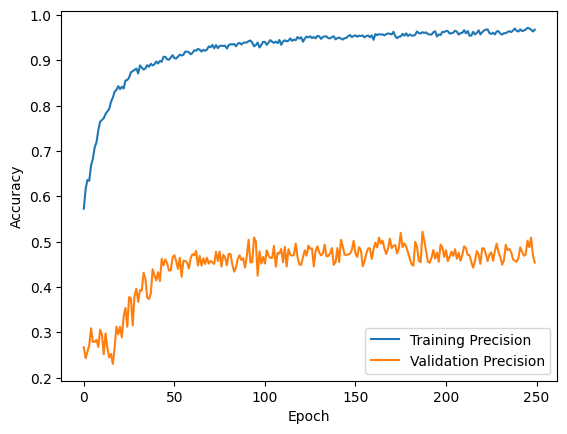

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['precision'], label='Training Precision')
# plt.plot(y_pred, label='Testing Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Player List Prediction

In [17]:
list_df = pd.read_csv('../../../lib/ai_bum_list.csv')

list_df.drop(list_df['skaterFullName'].loc[list_df['skaterFullName'] == 'Taylor Hall'].index, inplace=True)
list_df['avgPowerplayToi'] = list_df['avgPowerplayToi'].apply(lambda x: datetime.strptime(str(x), "%M:%S").second + datetime.strptime(str(x), "%M:%S").minute * 60)
list_df['position'].replace(['C', 'R', 'L', 'D'], [2, 2, 2, 1], inplace=True)

features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_G', 'team_GA', 'team_PP%', 'PPGF', 'PPG/PG', 'PPO/PG',
            'PPTOI/PG', 'PEN', 'PENMin', 'team_PEN/GP', 'PENSeconds/PG', 'PENDrawn/GP', 'PPGA', 'team_PK%', 'PKTIO/PG', 'enemy_G', 'enemy_GA', 'enemy_PP%',
            'PPGF_enemy', 'PPG/PG_enemy', 'PPO/PG_enemy', 'PPTOI/PG_enemy', 'PEN_enemy', 'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENDrawn/GP_enemy',
            'PPGA_enemy', 'enemy_PK%', 'PKTIO/PG_enemy']

# features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'PENDrawn/GP', 'PPGF', 'PPG/PG', 'PPO/PG', 'PEN_enemy', 
#             'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENSeconds/PG_enemy', 'PPGA_enemy', 'enemy_PK%']

list_df[features] = scaler.transform(list_df[features])

# Iterate over each row and reshape
reshaped_data_list = []
for index, row in list_df.iterrows():
    # reshaped_data = row[features].values.reshape(1, 1, len(features))
    reshaped_data = row[features].values.reshape(1, len(features))
    reshaped_data_list.append(reshaped_data)


# Convert the list to a NumPy array
reshaped_data_array = np.array(reshaped_data_list, dtype=np.float32)

predictions = []
for i in reshaped_data_array:
    pred = model.predict(i, verbose=0)
    predictions.append(pred[0][0])

# Return scaled data to normal
list_df['prediction'] = predictions

list_df[features] = scaler.inverse_transform(list_df[features])
list_df.sort_values(by='prediction', ascending=False).to_csv('rnn_preds.csv')


In [18]:
pred_list = pd.read_csv('rnn_preds.csv')


# display = ['skaterFullName', 'teamAbbrevs', 'ppPoints', 'ppUnit', 'team_PP%', 'vs', 'enemy_PP%', 'enemy_PK%', 'enemy_PEN/GP', 'prediction', 'odds']
display = ['skaterFullName', 'teamAbbrevs', 'ppPoints', 'ppUnit', 'team_PP%', 'vs', 'enemy_PP%', 'enemy_PK%', 'enemy_PEN/GP', 'prediction']

pred_list['prediction'] = pred_list['prediction'].apply(lambda x: round(x, 5))

# Grab only the top predictions based on the threshold
threshold = 0.5
top_threshold = pred_list[pred_list['prediction'] > threshold]


print(f'Threshold of {threshold*100}%')

Threshold of 50.0%


In [19]:
# top_threshold['odds'] = odds
top_threshold[display]

,skaterFullName,teamAbbrevs,ppPoints,ppUnit,team_PP%,vs,enemy_PP%,enemy_PK%,enemy_PEN/GP,prediction
0,Jamie Benn,DAL,10.0,1.0,0.22535,TOR,0.25,0.77777,3.695784,0.78289
1,Joe Pavelski,DAL,13.0,1.0,0.22535,TOR,0.25,0.77777,3.695784,0.57778
